# Task 2: Does the test Stimulus (independent variable) have a significant influence on speech quality ratings (dependent variable)? If yes, for which cases? Please assume that each of the six files was assessed by a different set of test participants AND ONLY USE RATINGS OF THE FIRST REPETITION (repetition = 1). Use the quality ratings provided in the data set speech_quality_repetition_dataset.

### Step 1: Import libraries and read in data set

In [1]:
# install.packages('dplyr')                                          # processing 
# install.packages('gdata')                                          # file reading
# install.packages('tidyverse')                                      # ggplot2 plot library
# install.packages('gridExtra')                                      # subplotting
# install.packages('rstatix')                                        # effect size
# install.packages('reshape2')                                       # formatting post hoc test results
# install.packages('coin', repos='http://R-Forge.R-project.org')     # effect size for Mann Whitney U Test

In [2]:
library(dplyr)     # processing
library(readxl)    # reading in data
library(rstatix)   # effect size
library(ggplot2)   # ggplot2 plot library
library(gridExtra) # subplotting
library(reshape2)  # formatting post hoc test results
library(coin)      # effect size for Mann Whitney U Test
library(reshape2)

Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'rstatix' was built under R version 3.6.2"
Attaching package: 'rstatix'

The following object is masked from 'package:stats':

    filter

Warning message:
"package 'gridExtra' was built under R version 3.6.2"
Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Warning message:
"package 'coin' was built under R version 3.6.2"Loading required package: survival

Attaching package: 'coin'

The following objects are masked from 'package:rstatix':

    chisq_test, friedman_test, kruskal_test, sign_test, wilcox_test



In [3]:
# read in data set

get_quality_data <- function() {
    quality_data <- read.csv("datasets/DB03_speech_quality_repetition_dataset.csv")
    # use mean here as indicator of given rating per participant
    quality_data <- quality_data %>% 
                        filter(repetition == 1) %>%
                        rename(Stimulus = testStimulus, Rating = rating) %>%
                        select(Stimulus, Rating) %>% 
                        arrange(Stimulus) 
    
    quality_data
}

quality_data <- get_quality_data()
head(quality_data)

Stimulus,Rating
haus_m_700_bpf_200_2800_normAsl_-26,2
haus_m_700_bpf_200_2800_normAsl_-26,2
haus_m_700_bpf_200_2800_normAsl_-26,3
haus_m_700_bpf_200_2800_normAsl_-26,3
haus_m_700_bpf_200_2800_normAsl_-26,2
haus_m_700_bpf_200_2800_normAsl_-26,1


### Step 2: Decide on which non-parametric test to use

#### => 1 independent input variable (testStimulus) with several distinct values (6 stimuli), 1 dependent variable (Rating), NOT repeated measures but independent ratings between different stimuli => Kruskal-Wallis Test

### Step 3: Check assumptions

#### 1. Measurements at least at ordinal level => OK: Rating is interval-scaled
#### 2. More than two groups in independent variable => OK: there are six different observed stimuli (6 groups)
#### 3. Independence of observations => OK: we assume that each of the six files has been assessed by a different set of raters
#### (4. Same shape => no (see the plot below), therefore comparison of mean ranks (internally))

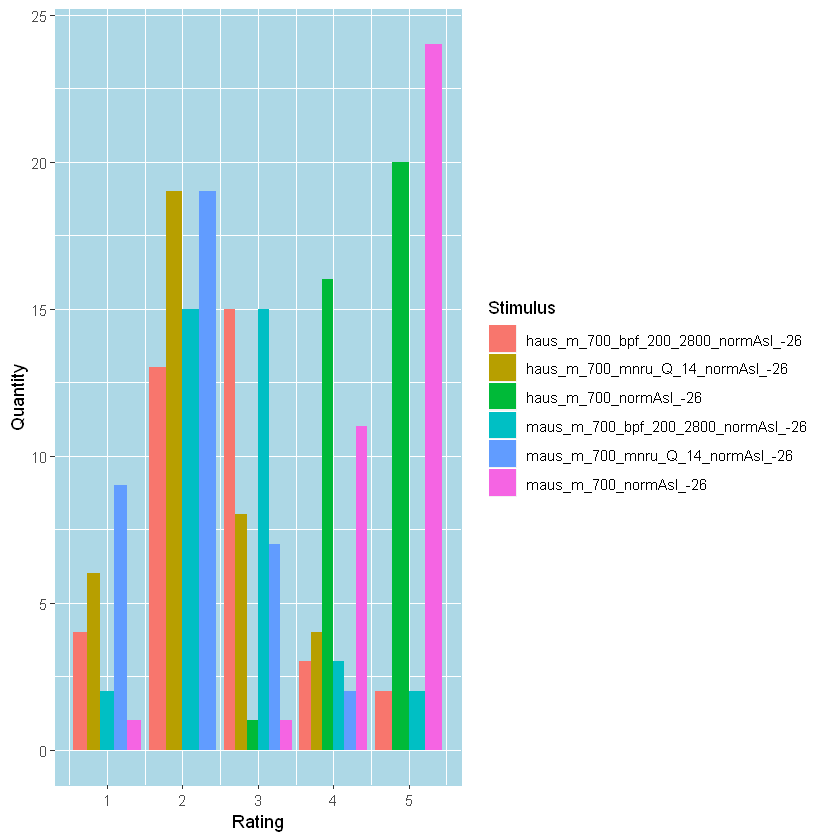

In [4]:
# visualization of distributions' shapes

plot_input <- quality_data %>% group_by(Stimulus, Rating) %>% summarize(Quantity=n()) %>% arrange(Stimulus, Rating)
ggplot(plot_input, aes(x=Rating, y=Quantity, fill=Stimulus)) +
    geom_bar(stat='identity', position='dodge') + 
    theme(panel.background = element_rect(fill = "lightblue", colour = "lightblue"))

#### => All assumptions required for the Kruskal-Wallis Test are met!

### Step 4: Conduct Kruskal-Wallis Test

In [5]:
# Conduct Kruskal-Wallis Test

kruskal.test(Rating ~ Stimulus, quality_data)


	Kruskal-Wallis rank sum test

data:  Rating by Stimulus
Kruskal-Wallis chi-squared = 130.9, df = 5, p-value < 2.2e-16


In [6]:
# Compute effect size for Kruskal-Wallis Test

kruskal_effsize(quality_data, Rating ~ Stimulus)

.y.,n,effsize,method,magnitude
Rating,222,0.5828585,eta2[H],large


#### Based on the results of the Kruskal-Wallis Test, the p value is far smaller than 0.001 (around 0) and the effect size (eta^2) is of large magnitude. We hereby assume that the (test)Stimulus has a significant impact on the speech quality ratings. More on that: see interpretation.

### Step 5: Pairwise comparison / post hoc test

#### Two groups (stimuli) in pair and independence between these can be assumed as each of the six stimuli was assessed by a different set of raters => Mann–Whitney U test aka Wilcoxon rank-sum test as post-hoc test

#### Checking assumptions for Mann–Whitney U test:
#### 1. Dependent variable at least ordinal (check, as Rating is interval-scaled)
#### 2. Two independent groups (check, as pairwise comparisons and each of the six stimuli was assessed by a different set of raters)
#### 3. Similar shape of pairs' distributions: don't know, let's look at the following plots!

In [7]:
# plots single pair histogram for given pair data
plot_histogram <- function(data, stimulus1, stimulus2) {   
    
    median1 <- median((data %>% filter(Stimulus == stimulus1))[['Rating']])
    median2 <- median((data %>% filter(Stimulus == stimulus2))[['Rating']])
    
    print(ggplot(data, aes(Rating, fill=Stimulus)) + 
        geom_histogram(alpha = 0.5, position = 'identity', bins = 25) + 
         theme(panel.background = element_rect(fill = "lightblue", colour = "lightblue")) +
            ggtitle(
                paste0('Comparison of distributions: \n', 
                        stimulus1, 
                        ' (median: ', 
                        median1, ') & \n',
                        stimulus2, 
                        ' (median: ', 
                        median2, ')')
            )
    )
}

# plots histograms for all passed pairs
plot_pairs <- function(stimuli_combinations) {
    plots <- list()
    for (row in 1:nrow(stimuli_combinations)) {
        # setting up the data frame for the current pairwise comparison and plotting it
        
        data <- quality_data %>% 
                    filter(Stimulus == stimuli_combinations[row,][['Stimulus1']] | 
                           Stimulus == stimuli_combinations[row,][['Stimulus2']])
        plot_histogram(data, stimuli_combinations[row,][['Stimulus1']], stimuli_combinations[row,][['Stimulus2']])
    }
}

In [8]:
# finding all possible stimuli pairs without duplications

stimuli <- (quality_data %>% distinct(Stimulus))[['Stimulus']]
all_stimuli_combinations <- expand.grid(stimuli, stimuli) %>% filter(Var1 != Var2) # remove self-comparisons
all_stimuli_combinations <- t(apply(all_stimuli_combinations, 1, sort)) # sort pairs
all_stimuli_combinations <- all_stimuli_combinations[!duplicated(all_stimuli_combinations),] # remove duplicates
colnames(all_stimuli_combinations) <- c('Stimulus1', 'Stimulus2') # add column names

all_stimuli_combinations

Stimulus1,Stimulus2
haus_m_700_bpf_200_2800_normAsl_-26,haus_m_700_mnru_Q_14_normAsl_-26
haus_m_700_bpf_200_2800_normAsl_-26,haus_m_700_normAsl_-26
haus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_bpf_200_2800_normAsl_-26
haus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_mnru_Q_14_normAsl_-26
haus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_normAsl_-26
haus_m_700_mnru_Q_14_normAsl_-26,haus_m_700_normAsl_-26
haus_m_700_mnru_Q_14_normAsl_-26,maus_m_700_bpf_200_2800_normAsl_-26
haus_m_700_mnru_Q_14_normAsl_-26,maus_m_700_mnru_Q_14_normAsl_-26
haus_m_700_mnru_Q_14_normAsl_-26,maus_m_700_normAsl_-26
haus_m_700_normAsl_-26,maus_m_700_bpf_200_2800_normAsl_-26


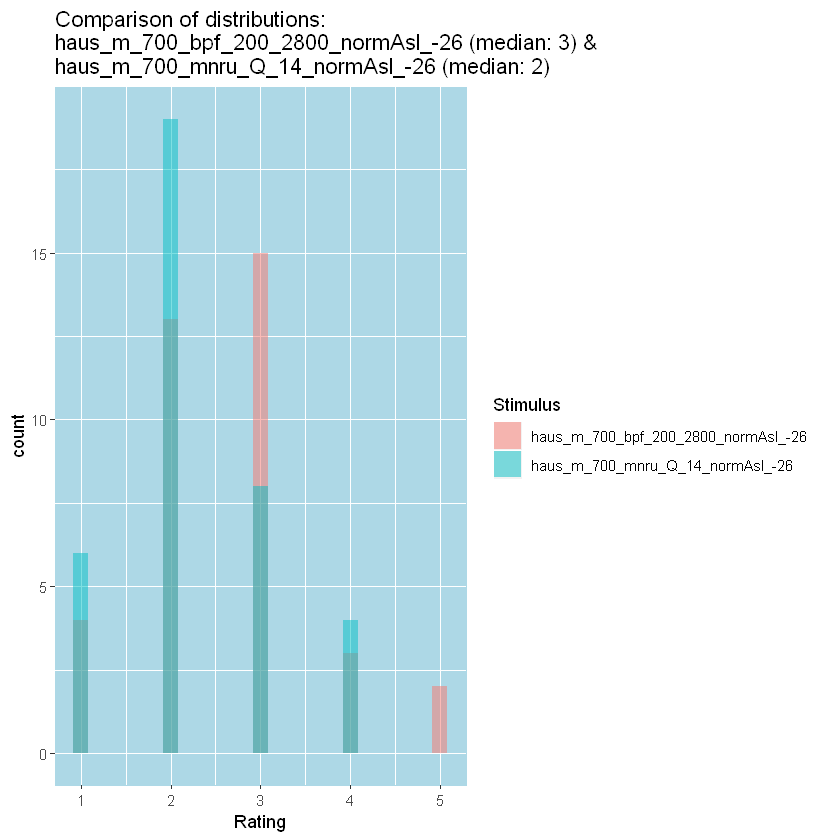

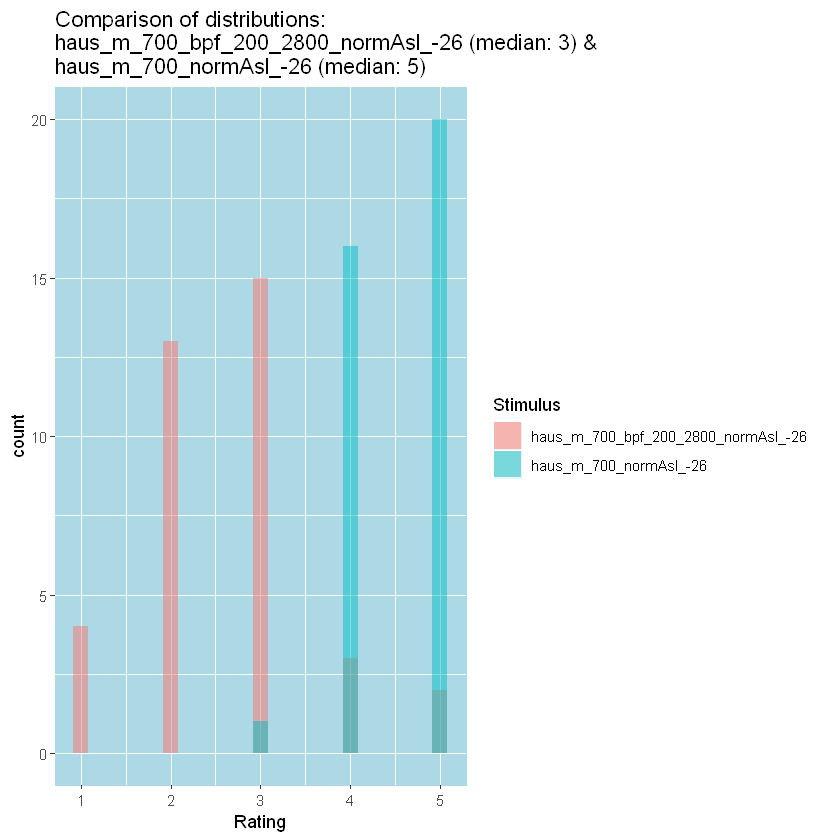

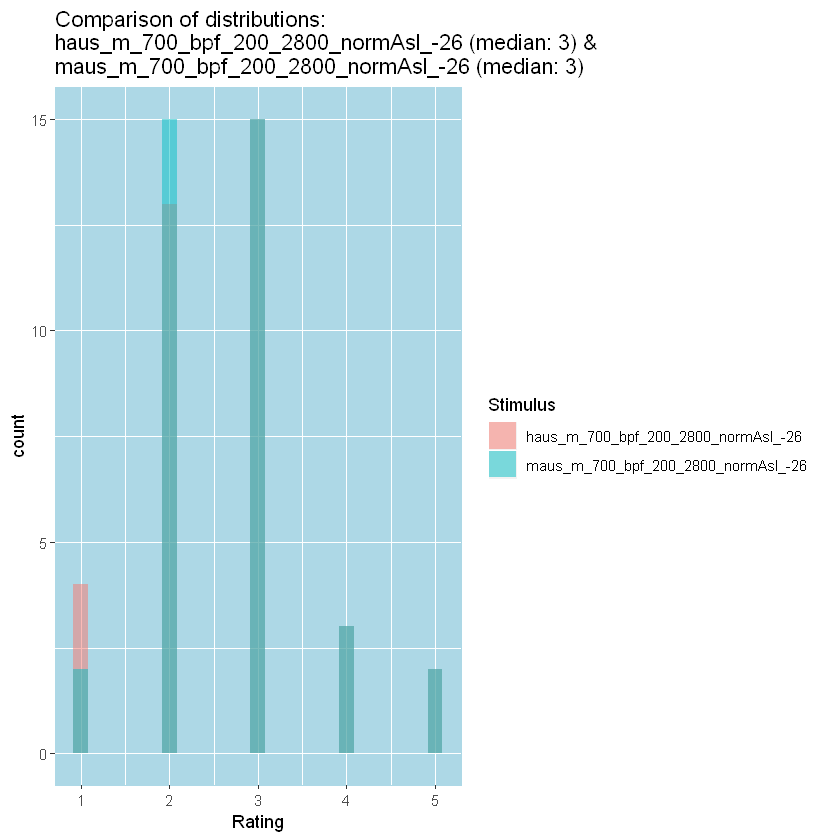

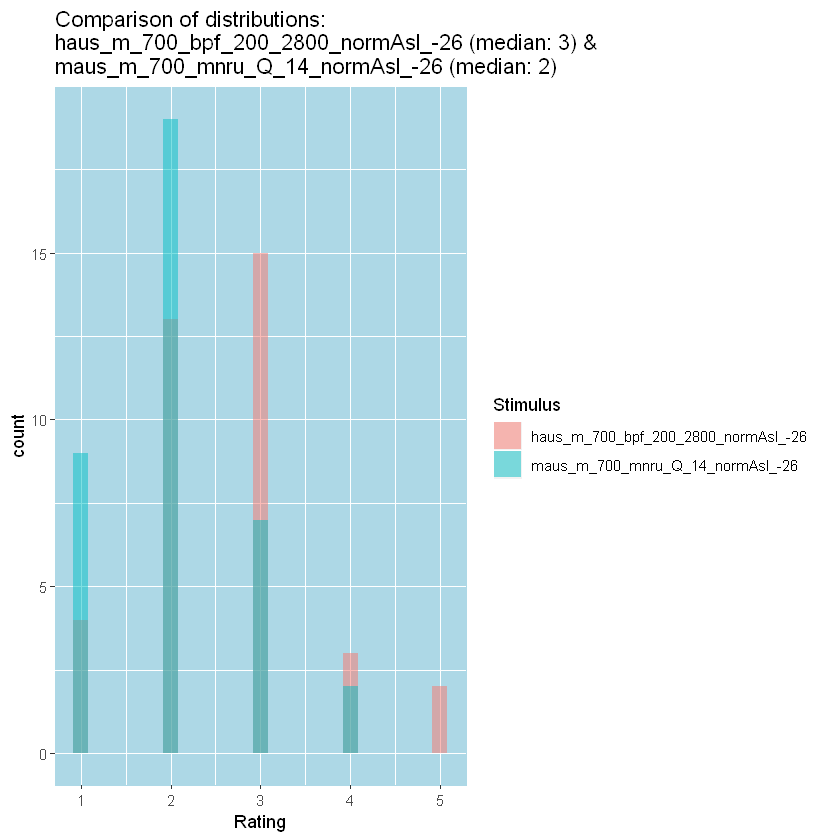

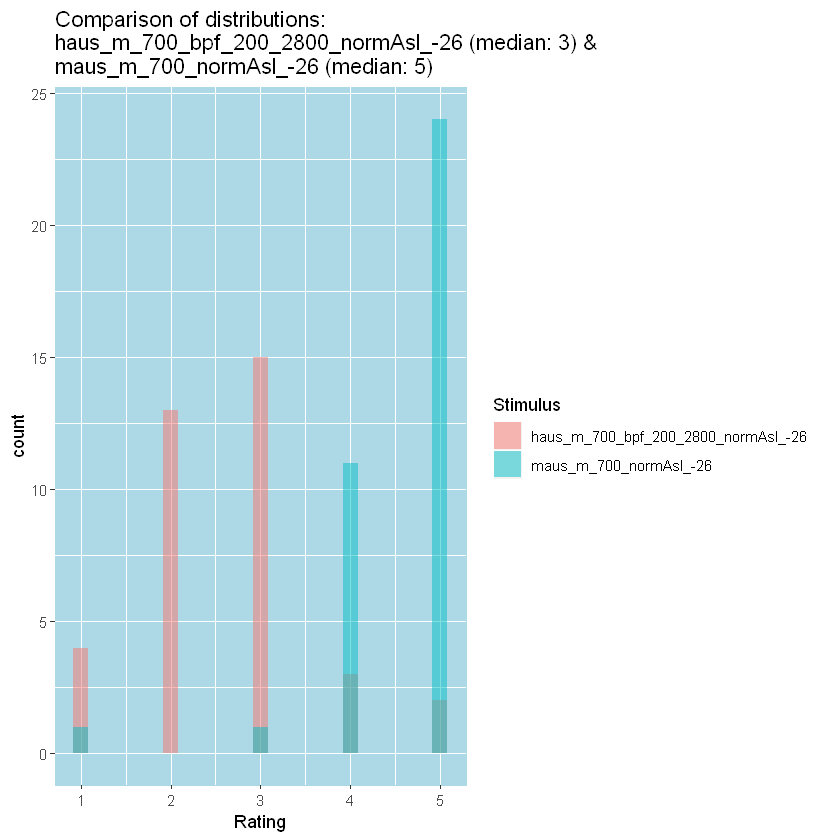

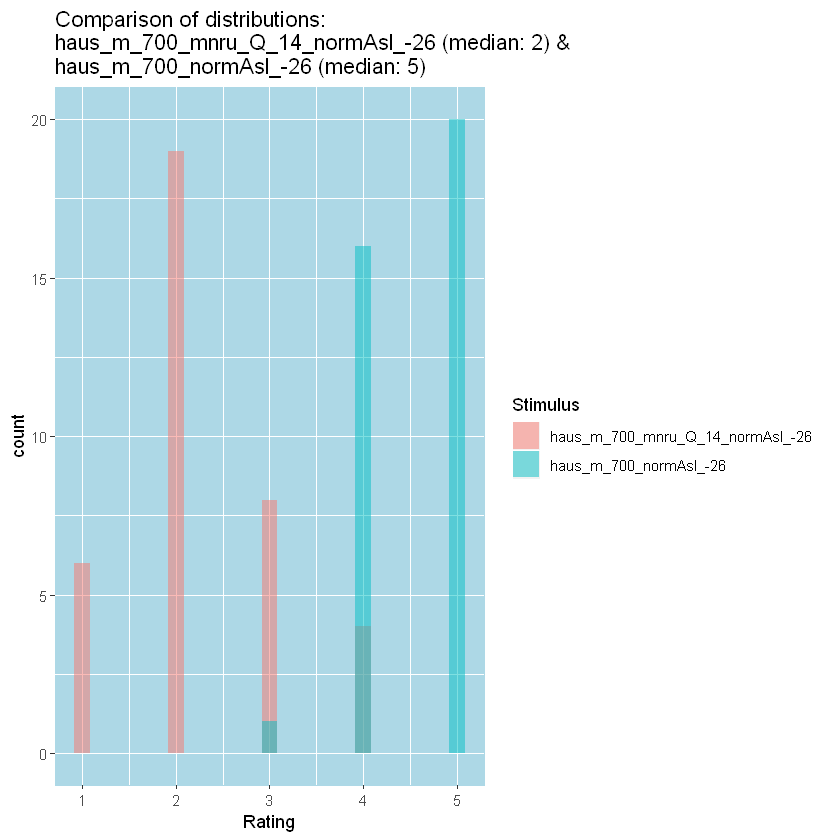

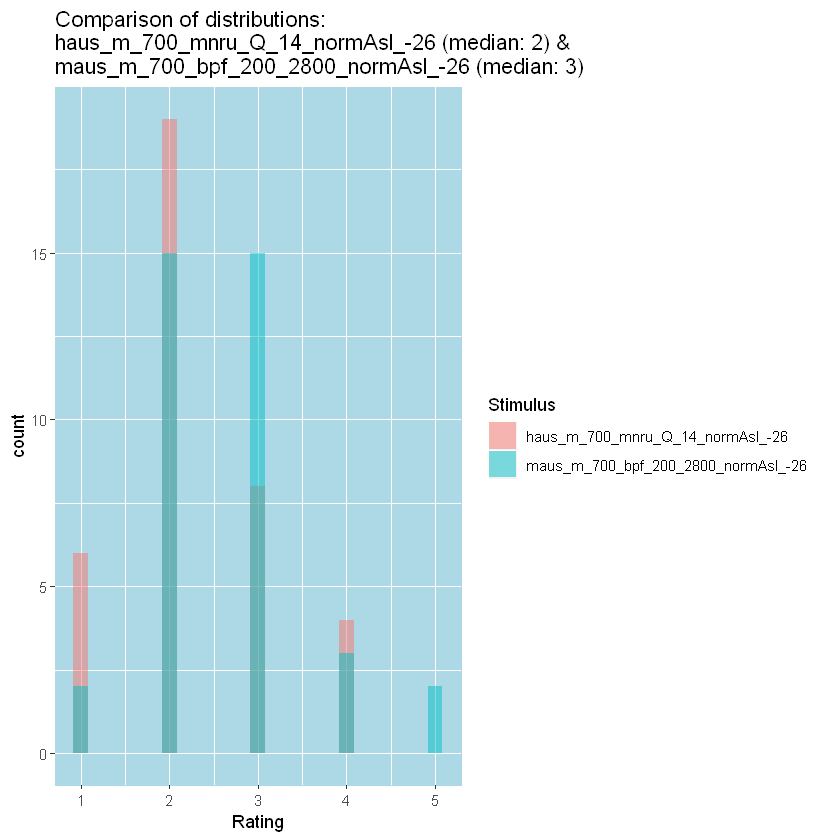

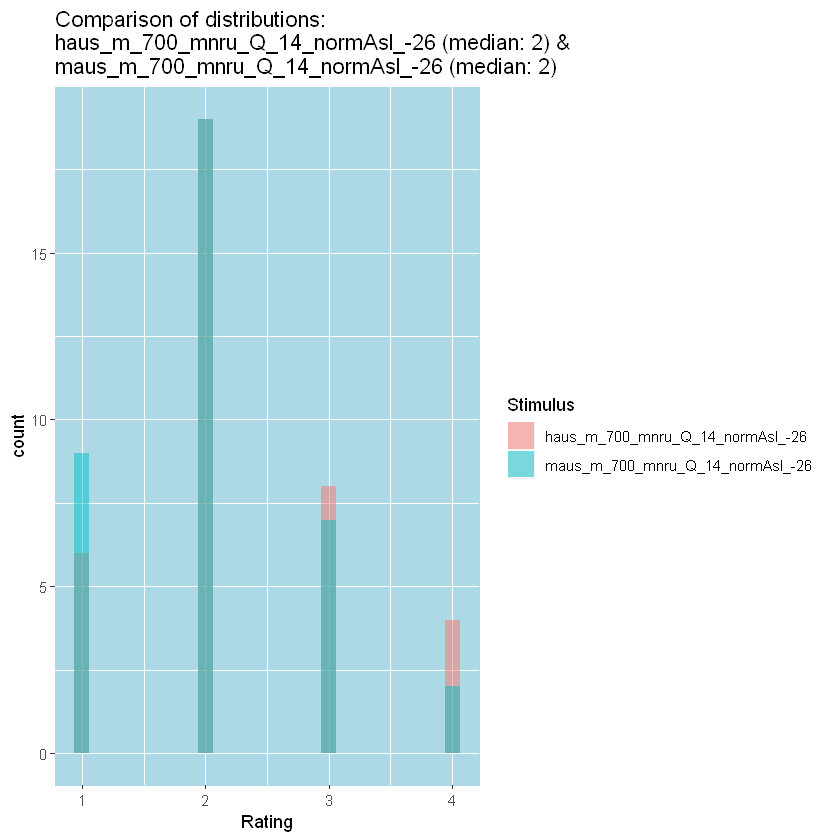

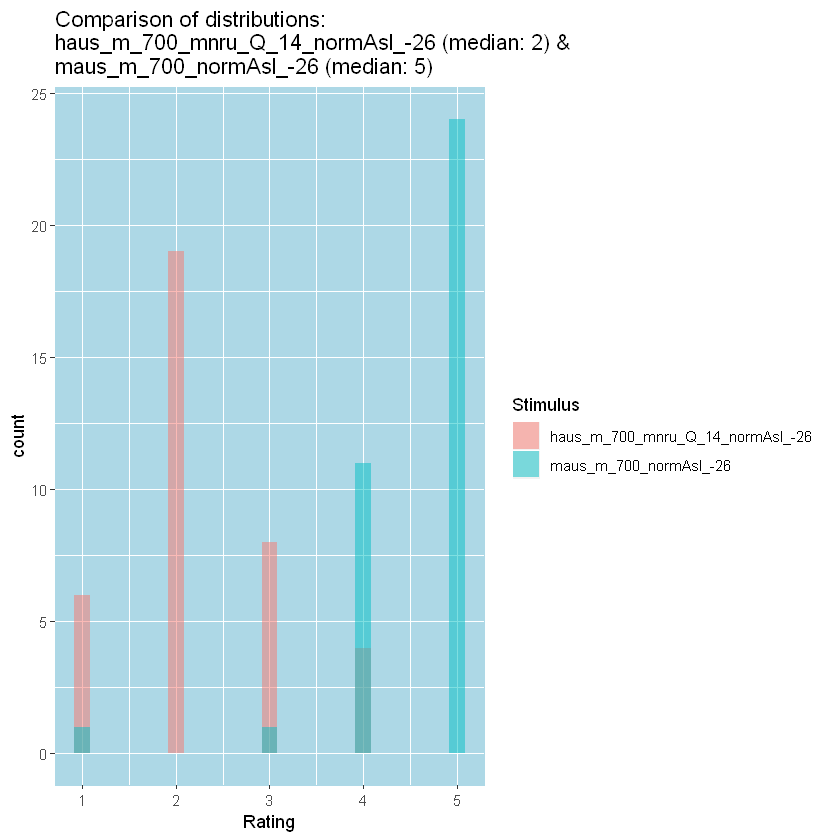

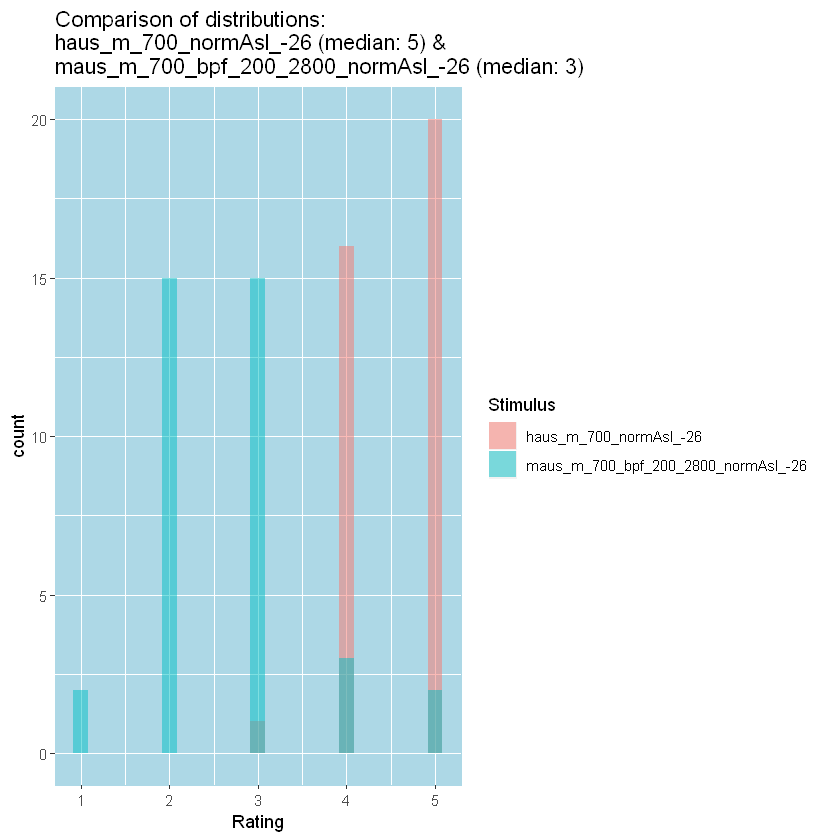

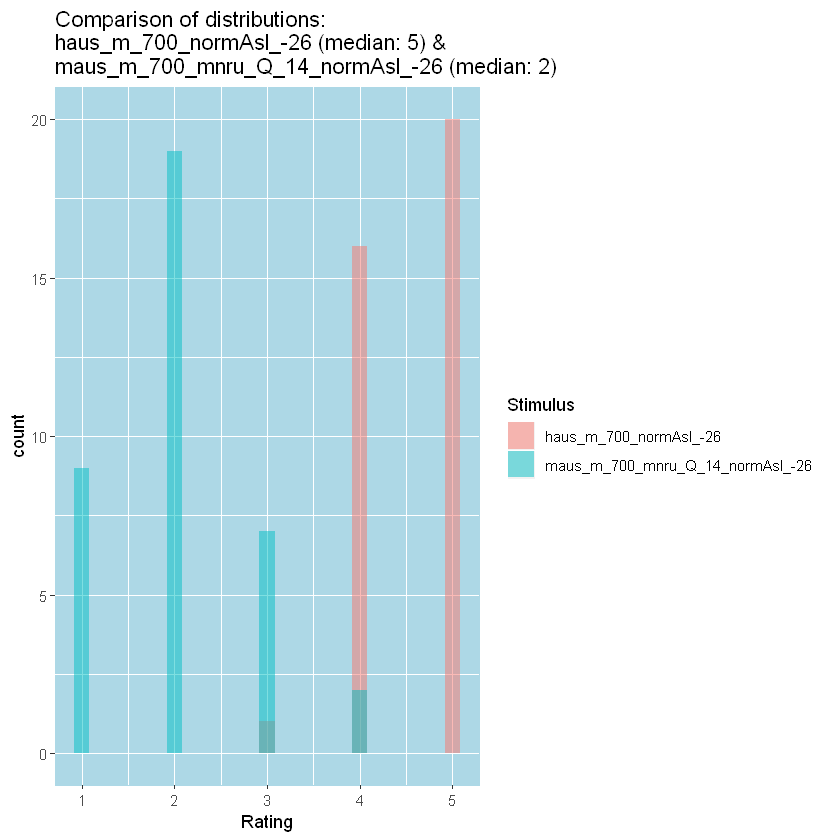

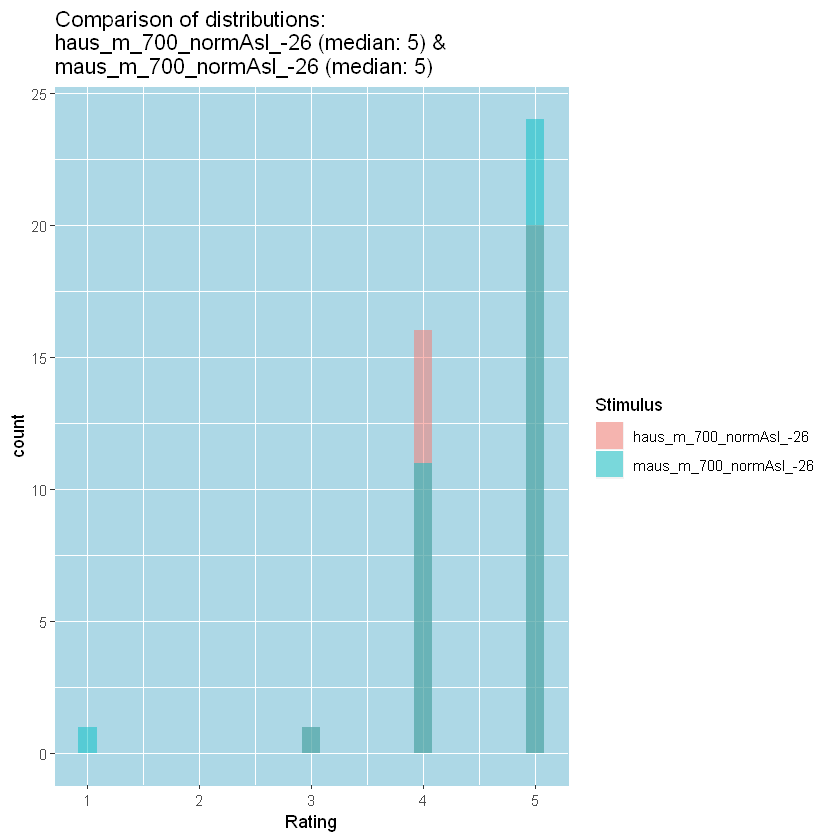

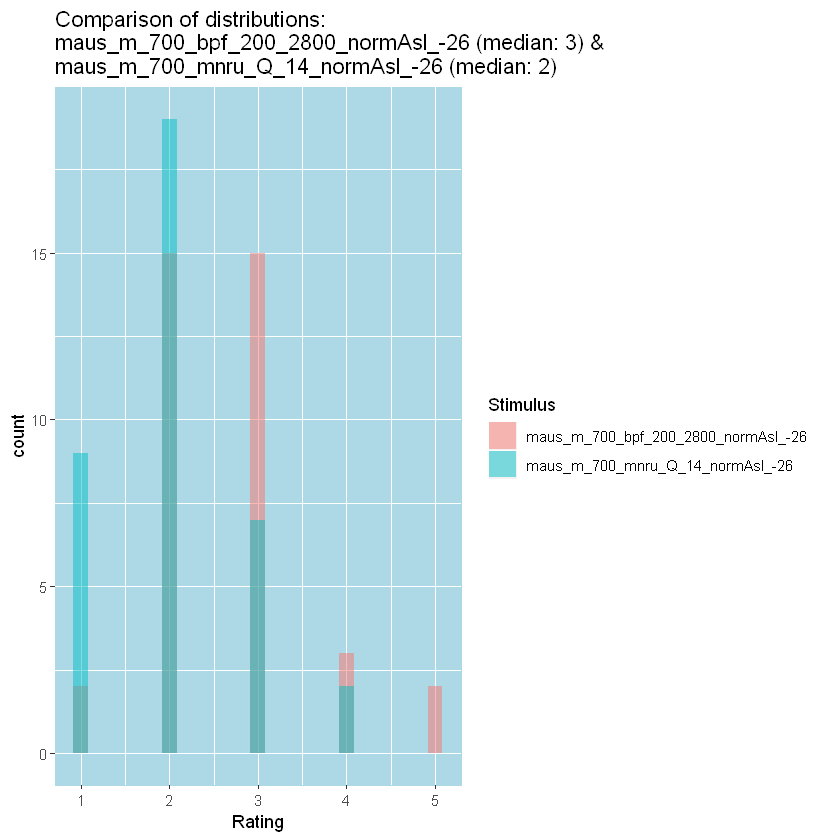

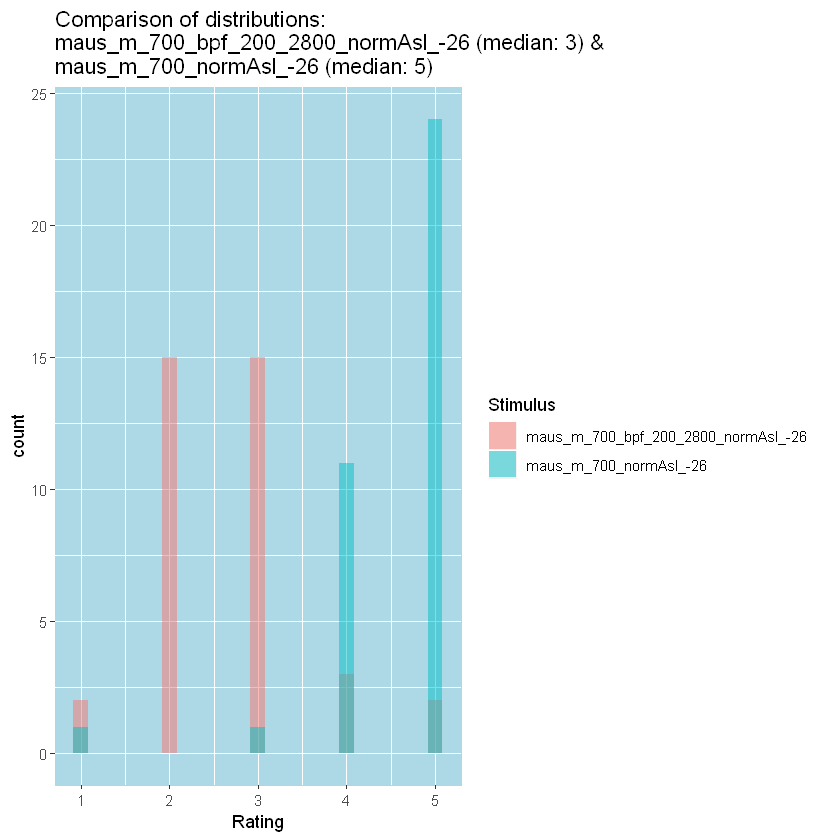

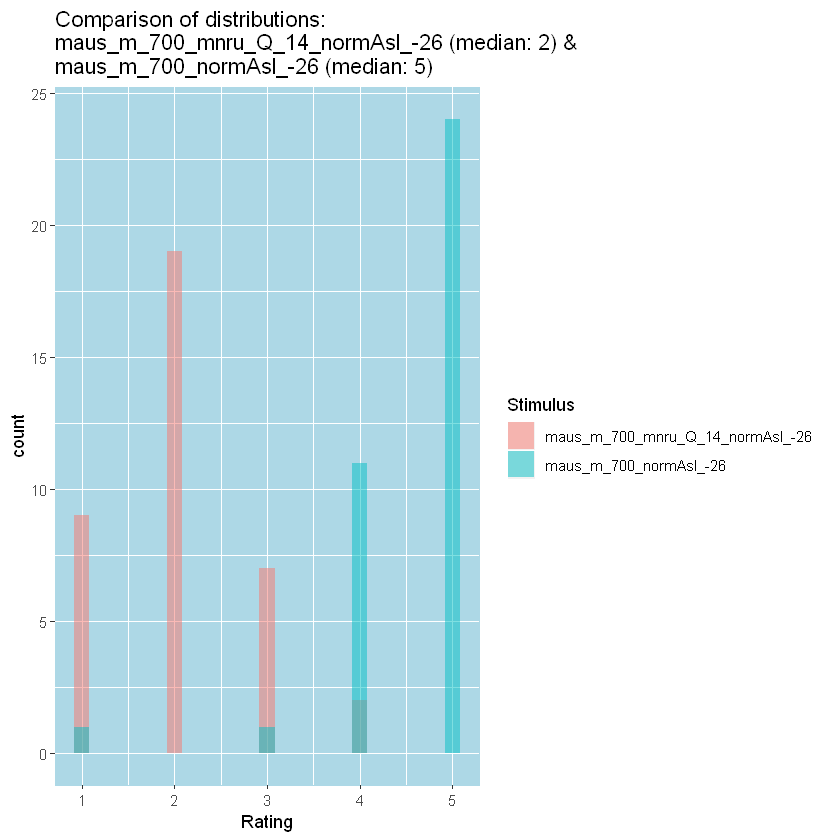

In [9]:
# plotting pairs to check assumption 3 of Mann–Whitney U test

plot_pairs(all_stimuli_combinations)

#### Therefore, we can assume similar distribution shapes for many pairs, but naturally not for all of them.

#### Conducting the post-hoc test

In [10]:
# Bonferroni correction to conservatively control Type I error

result <- pairwise.wilcox.test(quality_data$Rating, 
                               quality_data$Stimulus, 
                               paired=FALSE, exact=FALSE, 
                               p.adj='bonferroni')
result$method

# formatting
result <- melt(result$p.value) %>% 
            drop_na() %>% 
            rename(Stimulus1 = Var1, Stimulus2 = Var2, `Adjusted p value` = value) %>%
            arrange(desc(`Adjusted p value`))
result

[1] "Wilcoxon rank sum test"

Stimulus1,Stimulus2,Adjusted p value
haus_m_700_mnru_Q_14_normAsl_-26,haus_m_700_bpf_200_2800_normAsl_-26,1.000000e+00
maus_m_700_bpf_200_2800_normAsl_-26,haus_m_700_bpf_200_2800_normAsl_-26,1.000000e+00
maus_m_700_mnru_Q_14_normAsl_-26,haus_m_700_mnru_Q_14_normAsl_-26,1.000000e+00
maus_m_700_normAsl_-26,haus_m_700_normAsl_-26,1.000000e+00
maus_m_700_bpf_200_2800_normAsl_-26,haus_m_700_mnru_Q_14_normAsl_-26,7.852102e-01
maus_m_700_mnru_Q_14_normAsl_-26,haus_m_700_bpf_200_2800_normAsl_-26,1.331508e-01
maus_m_700_mnru_Q_14_normAsl_-26,maus_m_700_bpf_200_2800_normAsl_-26,4.591090e-02
maus_m_700_normAsl_-26,maus_m_700_bpf_200_2800_normAsl_-26,2.067790e-09
maus_m_700_normAsl_-26,haus_m_700_bpf_200_2800_normAsl_-26,2.040517e-09
haus_m_700_normAsl_-26,haus_m_700_bpf_200_2800_normAsl_-26,4.847684e-10


In [11]:
# Compute r effect size for Mann Whitney U Test (https://rpkgs.datanovia.com/rstatix/reference/wilcox_effsize.html)

quality_data %>% wilcox_effsize(Rating ~ Stimulus, paired = FALSE) %>% arrange(desc(effsize))

.y.,group1,group2,effsize,n1,n2,magnitude
Rating,haus_m_700_normAsl_-26,maus_m_700_mnru_Q_14_normAsl_-26,0.85664124,37,37,large
Rating,haus_m_700_mnru_Q_14_normAsl_-26,haus_m_700_normAsl_-26,0.83477901,37,37,large
Rating,maus_m_700_mnru_Q_14_normAsl_-26,maus_m_700_normAsl_-26,0.82375709,37,37,large
Rating,haus_m_700_mnru_Q_14_normAsl_-26,maus_m_700_normAsl_-26,0.80509403,37,37,large
Rating,haus_m_700_normAsl_-26,maus_m_700_bpf_200_2800_normAsl_-26,0.77315903,37,37,large
Rating,haus_m_700_bpf_200_2800_normAsl_-26,haus_m_700_normAsl_-26,0.77202083,37,37,large
Rating,haus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_normAsl_-26,0.74699114,37,37,large
Rating,maus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_normAsl_-26,0.74675708,37,37,large
Rating,maus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_mnru_Q_14_normAsl_-26,0.34494819,37,37,moderate
Rating,haus_m_700_bpf_200_2800_normAsl_-26,maus_m_700_mnru_Q_14_normAsl_-26,0.30485995,37,37,moderate


#### As we can see in the pairwise comparison results, the p values are smaller than 0.05 in all cases except for five (see above or in interpretation part). Therefore, altering the stimulus seems to have a significant impact on the speech quality ratings in most cases. This impression is also confirmed by the (r) effect sizes which are of large and moderate magnitude in all except for the five pairs.

### Step 6: Interpretation

In [12]:
# compute individual degrees of freedom for groups
get_df_of <- function(stimulus) {
    df <- (quality_data %>% dplyr::filter(Stimulus == stimulus) %>% 
            mutate(df = n() - 1))[1,][['df']]
    
    # print
    paste0('df = ', df)
}

cat(paste0('Total amount of samples: ', nrow(quality_data)))

Total amount of samples: 222

In [13]:
# compute statistics for independent variables' values
stimuli <- (quality_data %>% distinct(Stimulus))[['Stimulus']]
for (stimulus in stimuli) {
    statistics <- quality_data %>% 
                    filter(Stimulus == stimulus) %>%
                    group_by(Stimulus) %>%
                    summarize(mean = mean(Rating), sd = sd(Rating))
    cat(paste0(stimulus, ' (', get_df_of(stimulus), '): mean around ', round(statistics[['mean']], digits=3), ', standard deviation around ', round(statistics[['sd']], digits=3), '\n'))
}

haus_m_700_bpf_200_2800_normAsl_-26 (df = 36): mean around 2.622, standard deviation around 0.982
haus_m_700_mnru_Q_14_normAsl_-26 (df = 36): mean around 2.27, standard deviation around 0.871
haus_m_700_normAsl_-26 (df = 36): mean around 4.514, standard deviation around 0.559
maus_m_700_bpf_200_2800_normAsl_-26 (df = 36): mean around 2.676, standard deviation around 0.915
maus_m_700_mnru_Q_14_normAsl_-26 (df = 36): mean around 2.054, standard deviation around 0.815
maus_m_700_normAsl_-26 (df = 36): mean around 4.541, standard deviation around 0.803


#### Altering the (test)stimulus does indeed have a significant effect on the speech quality ratings (with selected alpha of 0.05):
#### There is a significant, rather large effect of the stimulus on the speech quality ratings (Kruskal-Wallis test's chi-squared statistic value of around 130.9, p-value of around 0 and large effect size of around 0.5829 (eta^2)).
#### The total degrees of freedom are the amount of total observations - 1 => 222 - 1 = 221 [or 37 - 1 = 36 degrees of freedom per distinct bitrate group and 5 for the Kruskal-Wallis Test].
#### Regarding pairwise comparisons / post hoc tests (pairwise Mann Whitney U Test [aka Wilcoxon Rank Sum Test] with Bonferroni correction for non-parametric tests), there is a statistically significant difference of speech quality ratings when altering the stimulus in every case except for five. These five cases are (sorted in descending order of p values):
#### Switching between haus_m_700_mnru_Q_14_normAsl_-26	(rating median: 2) & haus_m_700_bpf_200_2800_normAsl_-26 (rating median: 3) => p value of around 1, r effect size of around 0.1909
#### Switching between maus_m_700_bpf_200_2800_normAsl_-26 (rating median: 3) & haus_m_700_bpf_200_2800_normAsl_-26 (rating median: 3) => p value of around 1, r effect size of around 0.0228
#### Switching between maus_m_700_mnru_Q_14_normAsl_-26	(rating median: 2) & haus_m_700_mnru_Q_14_normAsl_-26 (rating median: 2) => p value of around 1, r effect size of around 0.1229
#### Switching between maus_m_700_normAsl_-26 (rating median: 5) & haus_m_700_normAsl_-26 (rating median: 5) => p value of around 1, r effect size of around 0.092
#### Switching between maus_m_700_bpf_200_2800_normAsl_-26 (rating median: 3) & haus_m_700_mnru_Q_14_normAsl_-26 (rating median: 2) => p value of around 0.7852, r effect size of around 0.2262
#### For more information like medians of the comparisons or p values / effect sizes / medians of the stimuli cases that indeed make a significant difference on speech quality ratings, please look above.